In [41]:
from tinygrad import Tensor, nn, TinyJit
import numpy as np
from common import word_generator, create_transition_matrix, draw_transition_matrix
from functools import reduce

In [35]:
names = open("./names.txt").read().splitlines()

In [36]:
empty_char_token = "."
vocab = [empty_char_token] + sorted(set("".join(names)))
vocab_size = len(vocab)

In [37]:
block_size = 4
X, y = [], []

for name in names:
  name_chars = [empty_char_token] * block_size + list(name) + [empty_char_token]
  for i in range(len(name_chars) - block_size):
    X.append([vocab.index(char) for char in name_chars[i : i + block_size]])
    y.append(vocab.index(name_chars[i + block_size]))


split = int(0.8 * len(X))
X_train, y_train, X_test, y_test = (
  Tensor(X[:split]),
  Tensor(y[:split]),
  Tensor(X[split:]),
  Tensor(y[split:]),
)

X_train, y_train, X_test, y_test

(<Tensor <LB CLANG (182516, 4) int (<MetaOps.COPY: 3>, None)> on CLANG with grad None>,
 <Tensor <LB CLANG (182516,) int (<MetaOps.COPY: 3>, None)> on CLANG with grad None>,
 <Tensor <LB CLANG (45630, 4) int (<MetaOps.COPY: 3>, None)> on CLANG with grad None>,
 <Tensor <LB CLANG (45630,) int (<MetaOps.COPY: 3>, None)> on CLANG with grad None>)

In [48]:
class EmbeddedMLP:
  def __init__(
    self,
    vocab_size,
    embed_size,
    input_size,
    output_size,
    h=[(200, Tensor.relu), (100, Tensor.relu)],
  ):
    self.input_size = input_size
    self.layers = [nn.Embedding(vocab_size, embed_size)]
    prev_layer_size = input_size * embed_size
    self.layers.append(lambda x: x.reshape((x.shape[0], -1)))
    for layer_size, layer_activation in h:
      self.layers.append(nn.Linear(prev_layer_size, layer_size))
      self.layers.append(layer_activation)
      prev_layer_size = layer_size
    self.layers.append(nn.Linear(prev_layer_size, output_size))

  def __call__(self, x: Tensor):
    assert len(x.shape) <= 2 and x.shape[-1] == self.input_size
    return reduce(lambda x, l: l(x), self.layers, x)


embedded_mlp = EmbeddedMLP(
  vocab_size, embed_size=10, input_size=block_size, output_size=vocab_size
)

In [49]:
optim = nn.optim.Adam(nn.state.get_parameters(embedded_mlp))
batch_size = 128


@TinyJit
@Tensor.train()
def train_step():
  optim.zero_grad()
  samples = Tensor.randint(batch_size, high=X_train.shape[0])
  X_samples, y_samples = X_train[samples], y_train[samples]
  loss = embedded_mlp(X_samples).sparse_categorical_crossentropy(y_samples).backward()
  optim.step()
  return loss

In [50]:
for step in range(1, 20001):
  loss = train_step()
  if step == 1 or step % 1000 == 0:
    Tensor.training = False
    acc = (embedded_mlp(X_test).argmax(axis=1) == y_test).mean().item()
    print(f"step {step}, loss {loss.item():.2f}, acc {acc*100.:.2f}%")

step 1, loss 3.32, acc 2.69%
step 1000, loss 2.40, acc 26.35%
step 2000, loss 2.27, acc 26.39%
step 3000, loss 2.21, acc 27.95%
step 4000, loss 2.11, acc 28.44%
step 5000, loss 2.15, acc 28.53%
step 6000, loss 2.10, acc 28.87%
step 7000, loss 2.21, acc 29.01%
step 8000, loss 1.92, acc 29.47%
step 9000, loss 1.84, acc 29.76%
step 10000, loss 1.97, acc 29.74%
step 11000, loss 1.74, acc 29.27%
step 12000, loss 1.89, acc 29.70%
step 13000, loss 1.97, acc 30.02%
step 14000, loss 2.03, acc 29.64%
step 15000, loss 1.96, acc 29.32%
step 16000, loss 2.05, acc 29.86%
step 17000, loss 1.87, acc 30.38%
step 18000, loss 2.17, acc 30.19%
step 19000, loss 1.83, acc 30.23%
step 20000, loss 2.04, acc 29.80%


In [51]:
@word_generator(
  block_size=block_size, empty_char=empty_char_token, max_size=float("inf")
)
def generate_word(prev_block: str):
  x = Tensor([vocab.index(char) for char in prev_block])
  y = embedded_mlp(x).squeeze()
  counts = y.exp()
  p = counts / counts.sum()
  return np.random.choice(a=vocab, p=p.numpy())

In [45]:
generated_names = []
for _ in range(32000):
  generated_names.append(generate_word())

generated_names[:1000]

['aelaina',
 'alexin',
 'kataryn',
 'tyan',
 'nerely',
 'inmli',
 'camderl',
 'kaleigh',
 'sargen',
 'kareon',
 'mena',
 'mostyson',
 'kimah',
 'laudiesh',
 'kelsey',
 'kasyann',
 'jazmen',
 'bra',
 'blae',
 'novannie',
 'sina',
 'rrol',
 'kessie',
 'veota',
 'wayrose',
 'dawhie',
 'brightaf',
 'anne',
 'ayana',
 'maraan',
 'xik',
 'payslia',
 'jadanney',
 'corro',
 'liay',
 'ammalyannav',
 'khhelle',
 'kinmleiah',
 'lavelendally',
 'kurysandrian',
 'kraigh',
 'dagge',
 'alucia',
 'gindlyson',
 'heis',
 'gacxelee',
 'bryley',
 'brayke',
 'magdalleigh',
 'rusten',
 'azen',
 'rhyanna',
 'madeth',
 'stel',
 'marvin',
 'des',
 'gryana',
 'mahely',
 'crezmajie',
 'calidi',
 'aani',
 'jaxshan',
 'rournion',
 'samoum',
 'gyonn',
 'merson',
 'hiro',
 'carley',
 'uzlynn',
 'hiylah',
 'anad',
 'marisha',
 'blayyan',
 'baylei',
 'dilyn',
 'aria',
 'daleya',
 'melah',
 'emmarian',
 'aara',
 'adiyah',
 'ifalijah',
 'aben',
 'monal',
 'dabiel',
 'alil',
 'vivik',
 'alayanna',
 'baltas',
 'feydyn',
 

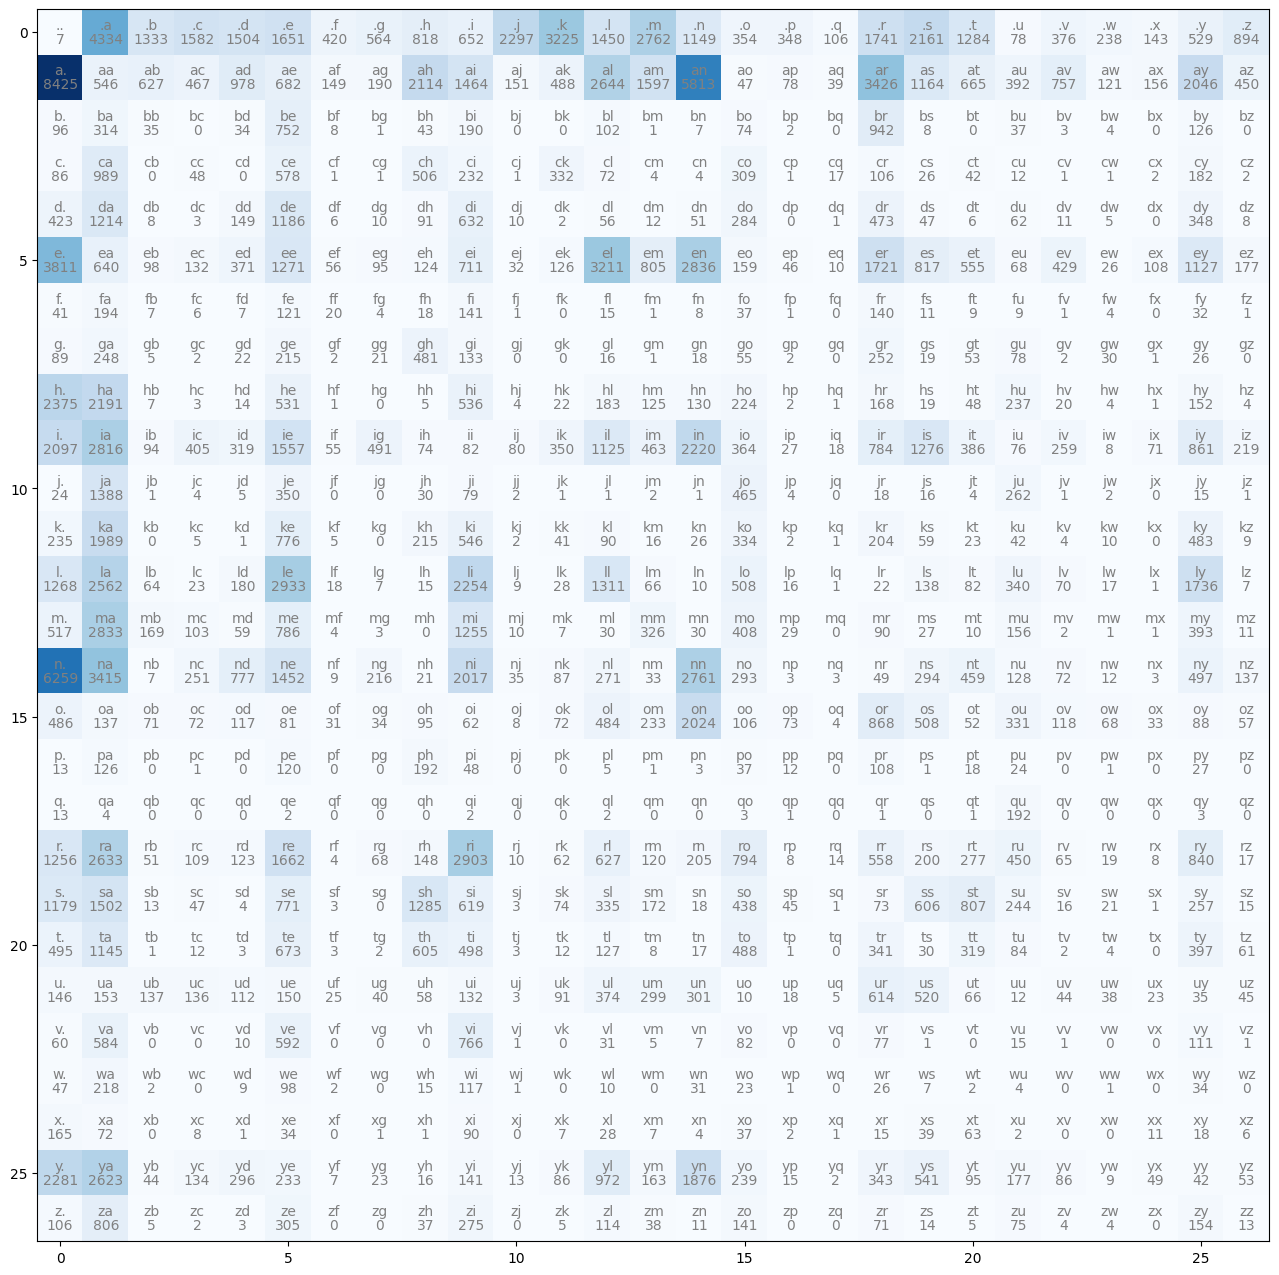

In [44]:
draw_transition_matrix(
  create_transition_matrix(generated_names, vocab, empty_char_token), vocab
)